# RoboCop AI: Crime Detector DNN
Imagine a futuristic city run by AI. The government deploys a Robot Police Cop (powered by a Deep Neural Network) to predict whether a person will commit a crime. But… the robot starts failing , it overfits to past crime data and can’t generalize to new situations. Now we retrain it with regularization to make it smarter and fairer.
![robo](robo.png)


In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasClassifier

In [2]:
import re

with open("communities.names", "r") as file:
    lines = file.readlines()

# Extract column names from @attribute lines
columns = []
for line in lines:
    match = re.match(r'@attribute\s+([^\s]+)\s+', line.strip(), re.IGNORECASE)
    if match:
        columns.append(match.group(1))

print("✅ Total columns extracted:", len(columns))  # Should be 128
print(columns[:5], "...", columns[-5:])  # Preview first/last columns


✅ Total columns extracted: 128
['state', 'county', 'community', 'communityname', 'fold'] ... ['LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop', 'ViolentCrimesPerPop']


In [3]:
df = pd.read_csv('communities.data', header=None, names=columns, na_values='?')

In [4]:
df

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


In [5]:
df.dropna(axis=1, thresh=len(df)*0.8, inplace=True)
df.dropna(inplace=True)
df['CrimeBinary'] = (df['ViolentCrimesPerPop'] > 0.5).astype(int)

In [6]:
df

,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop,CrimeBinary
0,8,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,...,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20,0
1,53,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,...,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67,1
2,24,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,...,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43,0
3,34,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,...,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12,0
4,42,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,...,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,0.16,0.43,...,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09,0
1990,6,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,0.32,0.69,...,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45,0
1991,9,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,...,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23,0
1992,25,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,...,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19,0


In [33]:
# Drop non-numeric columns first (like 'state', 'communityname')
X = df.drop(columns=['state', 'communityname', 'ViolentCrimesPerPop', 'CrimeBinary'])
y_reg = df['ViolentCrimesPerPop']
y_clf = df['CrimeBinary']

In [34]:
X

,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,...,0.00,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32
1,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,...,0.00,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00
2,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,...,0.00,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00
3,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,...,0.00,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00
4,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,...,0.00,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,10,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,...,0.00,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00
1990,10,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,...,0.00,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00
1991,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,...,0.02,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91
1992,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,...,0.01,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22


In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X_scaled, y_reg, y_clf, test_size=0.2, random_state=42
)

##  RoboCop v1 – Classification Model (No regularization) 

In [48]:
# 3. RoboCop v1 – Classification Model (No regularization)
def create_classifier_model(dropout_rate=0.0):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),     #Input(shape=(784))
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [50]:
#clf_model = create_classifier_model()

In [55]:
history_clf=clf_model.fit(X_train, y_train_clf, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/30
40/40 [==============================] - 1s 14ms/step - loss: 4.7722e-05 - accuracy: 1.0000 - val_loss: 1.0172 - val_accuracy: 0.8683
Epoch 2/30
40/40 [==============================] - 0s 12ms/step - loss: 4.6109e-05 - accuracy: 1.0000 - val_loss: 1.0216 - val_accuracy: 0.8683
Epoch 3/30
40/40 [==============================] - 0s 11ms/step - loss: 4.5789e-05 - accuracy: 1.0000 - val_loss: 1.0207 - val_accuracy: 0.8683
Epoch 4/30
40/40 [==============================] - 0s 10ms/step - loss: 4.4016e-05 - accuracy: 1.0000 - val_loss: 1.0249 - val_accuracy: 0.8683
Epoch 5/30
40/40 [==============================] - 0s 10ms/step - loss: 4.3267e-05 - accuracy: 1.0000 - val_loss: 1.0290 - val_accuracy: 0.8683
Epoch 6/30
40/40 [==============================] - 0s 11ms/step - loss: 4.2684e-05 - accuracy: 1.0000 - val_loss: 1.0328 - val_accuracy: 0.8683
Epoch 7/30
40/40 [==============================] - 0s 9ms/step - loss: 4.0375e-05 - accuracy: 1.0000 - val_loss: 1.0355 - val_acc

C:\Users\Memoona\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 129302 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Memoona\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 129302 missing from current font.
  font.set_text(s, 0, flags=flags)


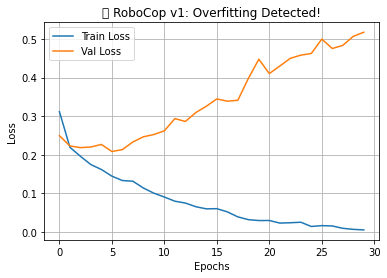

In [41]:
plt.plot(history_clf.history['loss'], label='Train Loss')
plt.plot(history_clf.history['val_loss'], label='Val Loss')
plt.title("🤖 RoboCop v1: Overfitting Detected!")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
y_pred_clf = (clf_model.predict(X_test) > 0.5).astype(int)
print("🔍 Classification Accuracy:", accuracy_score(y_test_clf, y_pred_clf))
print(classification_report(y_test_clf, y_pred_clf))


13/13 [==============================] - 0s 2ms/step
🔍 Classification Accuracy: 0.9047619047619048
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       349
           1       0.64      0.54      0.59        50

    accuracy                           0.90       399
   macro avg       0.79      0.75      0.77       399
weighted avg       0.90      0.90      0.90       399



## 🛡️ RoboCop v2: With Dropout & L2 Regularization

In [15]:

def create_regularized_classifier():
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [43]:
robocop_v2 = create_regularized_classifier()
history_v2 = robocop_v2.fit(X_train, y_train_clf, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/30
40/40 [==============================] - 7s 114ms/step - loss: 0.5196 - accuracy: 0.8722 - val_loss: 0.4294 - val_accuracy: 0.9060
Epoch 2/30
40/40 [==============================] - 0s 8ms/step - loss: 0.4514 - accuracy: 0.8871 - val_loss: 0.4113 - val_accuracy: 0.9028
Epoch 3/30
40/40 [==============================] - 0s 8ms/step - loss: 0.4278 - accuracy: 0.8886 - val_loss: 0.4073 - val_accuracy: 0.8997
Epoch 4/30
40/40 [==============================] - 0s 8ms/step - loss: 0.3805 - accuracy: 0.9153 - val_loss: 0.3916 - val_accuracy: 0.9028
Epoch 5/30
40/40 [==============================] - 0s 8ms/step - loss: 0.3808 - accuracy: 0.9067 - val_loss: 0.3876 - val_accuracy: 0.8997
Epoch 6/30
40/40 [==============================] - 0s 8ms/step - loss: 0.3648 - accuracy: 0.9059 - val_loss: 0.3706 - val_accuracy: 0.9028
Epoch 7/30
40/40 [==============================] - 0s 8ms/step - loss: 0.3520 - accuracy: 0.9098 - val_loss: 0.3666 - val_accuracy: 0.9060
Epoch 8/30
40/40 [

C:\Users\Memoona\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128736 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Memoona\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128736 missing from current font.
  font.set_text(s, 0, flags=flags)


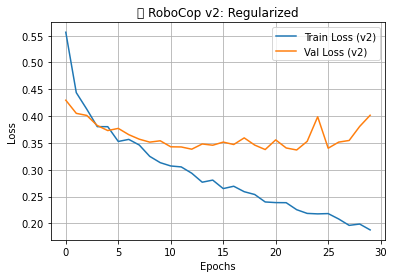

In [17]:
#📈 Improved plot
plt.plot(history_v2.history['loss'], label='Train Loss (v2)')
plt.plot(history_v2.history['val_loss'], label='Val Loss (v2)')
plt.title("🛠️ RoboCop v2: Regularized")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
y_pred_clf = (robocop_v2.predict(X_test) > 0.5).astype(int)
print("🔍 Classification Accuracy:", accuracy_score(y_test_clf, y_pred_clf))
print(classification_report(y_test_clf, y_pred_clf))


13/13 [==============================] - 0s 4ms/step
🔍 Classification Accuracy: 0.8947368421052632
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       349
           1       0.59      0.54      0.56        50

    accuracy                           0.89       399
   macro avg       0.76      0.74      0.75       399
weighted avg       0.89      0.89      0.89       399



##  RoboCop v1 – Regression Model (Crime Rate Prediction)

In [19]:
# 4. RoboCop v1 – Regression Model (Crime Rate Prediction)
def create_regression_model(dropout_rate=0.0):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [20]:
reg_model = create_regression_model()
reg_model.fit(X_train, y_train_reg, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/30
40/40 [==============================] - 1s 7ms/step - loss: 0.1186 - mae: 0.2422 - val_loss: 0.0497 - val_mae: 0.1737
Epoch 2/30
40/40 [==============================] - 0s 5ms/step - loss: 0.0392 - mae: 0.1489 - val_loss: 0.0404 - val_mae: 0.1549
Epoch 3/30
40/40 [==============================] - 0s 4ms/step - loss: 0.0246 - mae: 0.1195 - val_loss: 0.0355 - val_mae: 0.1468
Epoch 4/30
40/40 [==============================] - 0s 4ms/step - loss: 0.0198 - mae: 0.1065 - val_loss: 0.0332 - val_mae: 0.1390
Epoch 5/30
40/40 [==============================] - 0s 4ms/step - loss: 0.0162 - mae: 0.0971 - val_loss: 0.0451 - val_mae: 0.1602
Epoch 6/30
40/40 [==============================] - 0s 5ms/step - loss: 0.0148 - mae: 0.0921 - val_loss: 0.0353 - val_mae: 0.1427
Epoch 7/30
40/40 [==============================] - 0s 5ms/step - loss: 0.0113 - mae: 0.0805 - val_loss: 0.0356 - val_mae: 0.1425
Epoch 8/30
40/40 [==============================] - 0s 4ms/step - loss: 0.0111 - mae: 0.07

In [21]:
y_pred_reg = reg_model.predict(X_test)
print("📈 Regression MSE:", mean_squared_error(y_test_reg, y_pred_reg))
print("📊 Regression R² Score:", r2_score(y_test_reg, y_pred_reg))

13/13 [==============================] - 0s 2ms/step
📈 Regression MSE: 0.031675830523879005
📊 Regression R² Score: 0.40309467745780914


## 🧠 RoboCop v3: GridSearchCV Hyperparameter Tuning

In [22]:
# 🧠 RoboCop v3: GridSearchCV Hyperparameter Tuning
def build_model(optimizer='adam', dropout_rate=0.3):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [29]:
model_cv = KerasClassifier(
    model=build_model,        # model-building function
    dropout_rate=0.3,         # ✅ default value to register parameter
    optimizer='adam',         # ✅ default value
    epochs=30,
    batch_size=32,
    verbose=0
)

In [30]:
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4], 
    'optimizer': ['adam', 'rmsprop']
}

In [56]:
grid = GridSearchCV(estimator=model_cv, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train_clf)

In [32]:
print("\n🤖 RoboCop v1 says: 'I'm arresting the wrong people!'")
print("🛡️ RoboCop v2 says: 'I'm more stable now, thanks to regularization and drop .'")
print("🔧 RoboCop v3 says: 'I've been fully optimized using GridSearch!'")
print("🏆 Best Parameters:", grid_result.best_params_)
print("✅ Cross-Validated Accuracy:", round(grid_result.best_score_, 4))


🤖 RoboCop v1 says: 'I'm arresting the wrong people!'
🛡️ RoboCop v2 says: 'I'm more stable now, thanks to regularization.'
🔧 RoboCop v3 says: 'I've been fully optimized using GridSearch!'
🏆 Best Parameters: {'dropout_rate': 0.2, 'optimizer': 'rmsprop'}
✅ Cross-Validated Accuracy: 0.9009
